# 추천시스템 기초 실습

과제를 함에 있어서 나름대로(?) 저만의 방식으로 풀어봤습니다...

## 0. 데이터 불러오기 및 탐색

데이터는 movielens에서 제공하는 데이터 중 하나로, 가장 크기가 작은 버전으로 가져왔습니다.
- movies.csv: 영화 제목과 영화 장르에 대한 데이터
- ratings.csv: user(사용자)-movie(아이템) 선호도 데이터
- tags.csv: user가 해당 movie에 부여한 tag 데이터

필요한 모듈과 데이터를 불러오고 가볍게 살펴보기로 했습니다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [267]:
movie = pd.read_csv('movies.csv')
rating = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [59]:
print(movie.shape)
movie

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [9]:
print(tags.shape)
tags.head()

(3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [10]:
print(rating.shape)
rating.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## 1. Content-based Filtering 실습

content-based filtering은 movie(아이템) 간의 유사도를 계산하여 해당 movie와 유사한 movie를 추천해주는 간단한 추천 알고리즘

제공된 데이터에서 movie의 콘텐츠를 확인할 수 있는 데이터는 movies.csv의 장르와 tags.csv의 태그 정보가 있음

In [149]:
# 아이템 간 유사도 계산을 위한 데이터프레임 만들기
# 열은 영화 장르가 될 수도 있고, 영화 태그가 될 수도 있음 (영화 태그의 경우 모든 영화에 대한 태그는 없음)

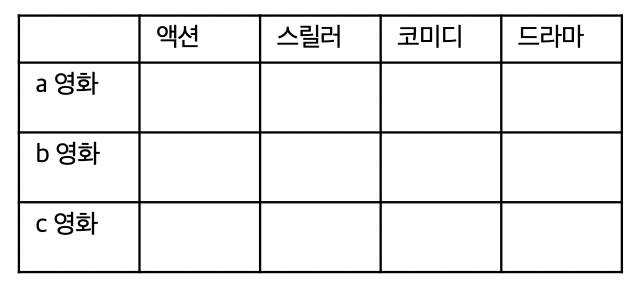

movie 데이터의 장르를 바탕으로 content-based filtering을 진행하겠습니다. movie의 genres의 경우 전처리가 필요합니다. 아래와 같이 약간의 전처리를 진행합시다

In [268]:
movie['genres'] = movie['genres'].apply(lambda x: x.split('|'))
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


아래의 pivot 테이블을 만들기 위해서 준비작업을 합니다. 여기서 뽑는 genre는 column명으로 쓰일 예정입니다. genre는 아래와 같이 추출합니다.

In [91]:
genre = []
for i in range(len(movie)):
    for j in movie['genres'][i]:
        if j not in genre:
            genre.append(j)

In [92]:
genre

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']

제대로 뽑힌 것을 확인할 수 있습니다. CountVectorizer를 사용해봤지만 sci와 fi, film과 noir로 분해되길래 포기했습니다.

piv라는 새로운 데이터 프레임을 만들어봅니다. 이 때, index는 movieId가 되고, columns는 위에서 뽑은 genre를 사용합니다.

In [269]:
piv = pd.DataFrame(index = movie['movieId'], columns = genre)
piv

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


이 후 각 영화의 장르를 입력해줍니다. 영화가 columns에 해당하는 장르라면 그 위치에 1을 넣어줍니다. 코드와 결과는 아래와 같습니다.

In [270]:
for i in range(len(piv)):
    for j in piv.columns:
        if j in movie.iloc[i]['genres']:
            piv.iloc[i][j] = 1
            
piv

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,1,NaN,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,1,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


columns의 순서에 약간의 차이는 있지만 보이는 결과는 같네요 :)

In [284]:
# 정답

# 해당 데이터프레임은 사용자-영화 선호도 행렬입니당
piv 

,(no genres listed),War,Mystery,Children,Drama,Romance,Animation,Comedy,Film-Noir,Musical,Horror,Crime,Fantasy,Western,Thriller,IMAX,Adventure,Sci-Fi,Action,Documentary
movieId,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,1,NaN,NaN,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN
2,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


===================================================================

In [ ]:
# TF-IDF를 적용할 수 있지만 여기서는 skip
# TF-IDF를 적용하게 되면 다음과 같이 나오긴 합니당

In [261]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
movie['corpus'] = movie['genres'].apply(lambda x : ' '.join(x.split('|')))

In [273]:
tfidv = TfidfVectorizer().fit(movie['corpus'])

In [278]:
temp = pd.DataFrame(tfidv.transform(movie['corpus']).toarray())

In [287]:
temp

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.000000,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.000000,0.482990,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.000000,0.593662,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.821009,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.505015,0.0,0.0,0.466405,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.726241,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0.436010,0.000000,0.614603,0.000000,0.318581,0.0,0.0,0.000000,0.575034,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9738,0.000000,0.000000,0.682937,0.000000,0.354002,0.0,0.0,0.000000,0.638968,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9739,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9740,0.578606,0.000000,0.815607,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


===================================================================

### 아이템 간 유사도 구하기

장르를 바탕으로 영화간의 유사도를 구해봅시다. 유사도는 코사인 유사도를 사용하며, 이는 sklearn에서 cosine_similarity로 제공하고 있습니다.

In [172]:
from sklearn.metrics.pairwise import cosine_similarity

유사도 계산을 위해서는 결측치 처리를 진행해야 합니다. fillna를 사용해 결측치들을 모두 0으로 만들어줍니다.

In [271]:
piv = piv.fillna(0)
piv

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
193583,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193585,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


유사도 계산 결과는 아래와 같이 나오네요.

In [272]:
CBF = pd.DataFrame(cosine_similarity(piv, piv))
CBF

,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
0,1.000000,0.774597,0.316228,0.258199,0.447214,0.000000,0.316228,0.632456,0.000000,0.258199,...,0.447214,0.316228,0.316228,0.447214,0.0,0.670820,0.774597,0.00000,0.316228,0.447214
1,0.774597,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.816497,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.288675,0.333333,0.00000,0.000000,0.000000
2,0.316228,0.000000,1.000000,0.816497,0.707107,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.353553,0.000000,0.500000,0.000000,0.0,0.353553,0.408248,0.00000,0.000000,0.707107
3,0.258199,0.000000,0.816497,1.000000,0.577350,0.000000,0.816497,0.000000,0.000000,0.000000,...,0.288675,0.408248,0.816497,0.000000,0.0,0.288675,0.333333,0.57735,0.000000,0.577350
4,0.447214,0.000000,0.707107,0.577350,1.000000,0.000000,0.707107,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.707107,0.000000,0.0,0.500000,0.577350,0.00000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0.670820,0.288675,0.353553,0.288675,0.500000,0.288675,0.353553,0.000000,0.500000,0.288675,...,0.750000,0.353553,0.353553,0.500000,0.0,1.000000,0.866025,0.00000,0.707107,0.500000
9738,0.774597,0.333333,0.408248,0.333333,0.577350,0.000000,0.408248,0.000000,0.000000,0.000000,...,0.577350,0.408248,0.408248,0.577350,0.0,0.866025,1.000000,0.00000,0.408248,0.577350
9739,0.000000,0.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.707107,0.707107,0.000000,0.0,0.000000,0.000000,1.00000,0.000000,0.000000
9740,0.316228,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.000000,0.707107,0.408248,...,0.707107,0.500000,0.000000,0.707107,0.0,0.707107,0.408248,0.00000,1.000000,0.000000


유사도을 계산한 행렬 CBF의 index와 columns 모두 movieId로 바꿔줍니다.

In [273]:
CBF.index = piv.index
CBF.columns = piv.index
CBF

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.774597,0.316228,0.258199,0.447214,0.000000,0.316228,0.632456,0.000000,0.258199,...,0.447214,0.316228,0.316228,0.447214,0.0,0.670820,0.774597,0.00000,0.316228,0.447214
2,0.774597,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.816497,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.288675,0.333333,0.00000,0.000000,0.000000
3,0.316228,0.000000,1.000000,0.816497,0.707107,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.353553,0.000000,0.500000,0.000000,0.0,0.353553,0.408248,0.00000,0.000000,0.707107
4,0.258199,0.000000,0.816497,1.000000,0.577350,0.000000,0.816497,0.000000,0.000000,0.000000,...,0.288675,0.408248,0.816497,0.000000,0.0,0.288675,0.333333,0.57735,0.000000,0.577350
5,0.447214,0.000000,0.707107,0.577350,1.000000,0.000000,0.707107,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.707107,0.000000,0.0,0.500000,0.577350,0.00000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.670820,0.288675,0.353553,0.288675,0.500000,0.288675,0.353553,0.000000,0.500000,0.288675,...,0.750000,0.353553,0.353553,0.500000,0.0,1.000000,0.866025,0.00000,0.707107,0.500000
193583,0.774597,0.333333,0.408248,0.333333,0.577350,0.000000,0.408248,0.000000,0.000000,0.000000,...,0.577350,0.408248,0.408248,0.577350,0.0,0.866025,1.000000,0.00000,0.408248,0.577350
193585,0.000000,0.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.707107,0.707107,0.000000,0.0,0.000000,0.000000,1.00000,0.000000,0.000000


아래의 정답과 보이는 값은 모두 같게 나왔네요 :)

===================================================================

In [288]:
# 정답

# 아이템 간 유사도 구하기
from sklearn.metrics.pairwise import cosine_similarity

In [291]:
# 영화-영화의 유사도를 코사인 유사도를 사용해서 구해줍니당
CBF = ???????????????

In [293]:
# movie - moive 아이템 간 유사도 데이터프레임
CBF.index = piv.index
CBF.columns = piv.index
CBF

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.774597,0.316228,0.258199,0.447214,0.000000,0.316228,0.632456,0.000000,0.258199,...,0.447214,0.316228,0.316228,0.447214,0.0,0.670820,0.774597,0.00000,0.316228,0.447214
2,0.774597,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.816497,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.288675,0.333333,0.00000,0.000000,0.000000
3,0.316228,0.000000,1.000000,0.816497,0.707107,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.353553,0.000000,0.500000,0.000000,0.0,0.353553,0.408248,0.00000,0.000000,0.707107
4,0.258199,0.000000,0.816497,1.000000,0.577350,0.000000,0.816497,0.000000,0.000000,0.000000,...,0.288675,0.408248,0.816497,0.000000,0.0,0.288675,0.333333,0.57735,0.000000,0.577350
5,0.447214,0.000000,0.707107,0.577350,1.000000,0.000000,0.707107,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.707107,0.000000,0.0,0.500000,0.577350,0.00000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.670820,0.288675,0.353553,0.288675,0.500000,0.288675,0.353553,0.000000,0.500000,0.288675,...,0.750000,0.353553,0.353553,0.500000,0.0,1.000000,0.866025,0.00000,0.707107,0.500000
193583,0.774597,0.333333,0.408248,0.333333,0.577350,0.000000,0.408248,0.000000,0.000000,0.000000,...,0.577350,0.408248,0.408248,0.577350,0.0,0.866025,1.000000,0.00000,0.408248,0.577350
193585,0.000000,0.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.707107,0.707107,0.000000,0.0,0.000000,0.000000,1.00000,0.000000,0.000000


==================================================================

전체적인 form은 정답과 비슷하게 만들려고 노력했습니다...코드와 결과는 아래와 같습니다. 모든 결과를 나타낸 것은 아니고 상위 10개의 값을 추출했습니다. 대부분은 정답과 유사하지만 한 2개...? 정도는 차이가 나네요...ㅠ

In [274]:
def getCBF(movieId):
    Id = movieId
    index = movie[movie['movieId'] == Id].index.values
    new_CBF = np.array(CBF)
    new_CBF = new_CBF.argsort()[:,::-1]
    
    print('입력 영화 :', movie['title'].loc[movie['movieId'] == Id].values[0])
    print('입력 영화 장르 :',movie['genres'].loc[movie['movieId'] == Id].values[0])
    print('=====Most similar List=====')
    
    sim_index = new_CBF[index,:].reshape(-1)
    sim_index = sim_index[sim_index != index]
    result = movie.iloc[sim_index][:10]    
    
    return result

In [275]:
getCBF(193583)

입력 영화 : No Game No Life: Zero (2017)
입력 영화 장르 : ['Animation', 'Comedy', 'Fantasy']
=====Most similar List=====


,movieId,title,genres
7368,79008,South Park: Imaginationland (2008),"[Animation, Comedy, Fantasy]"
8725,126577,"Daddy, I'm A Zombie (2012)","[Animation, Comedy, Fantasy]"
7199,72692,Mickey's Once Upon a Christmas (1999),"[Animation, Comedy, Fantasy]"
3098,4158,Monkeybone (2001),"[Animation, Comedy, Fantasy]"
9665,182297,Porky in Wackyland (1938),"[Animation, Comedy, Fantasy]"
4558,6773,"Triplets of Belleville, The (Les triplettes de...","[Animation, Comedy, Fantasy]"
4841,7228,Cool World (1992),"[Animation, Comedy, Fantasy]"
8999,139855,Anomalisa (2015),"[Animation, Comedy, Fantasy]"
6859,62336,FLCL (2000),"[Animation, Comedy, Fantasy, Sci-Fi]"
7184,72356,Partly Cloudy (2009),"[Animation, Children, Comedy, Fantasy]"


==================================================================

In [498]:
# 형식

# 각 영화와 다른 영화와의 유사도가 모두 계산되어 있고, 유사도가 높은 영화가 가장 비슷한 영화라고 할 수 있습니당
# 입력 아이템과 가장 유사한 아이템 TOP10개를 뽑아봅시당
def getCBF(movieId):
    '''
    
    ???????????????
    
    '''
    return

In [499]:
# 정답

getCBF(193583)

입력 영화: No Game No Life: Zero (2017)
입력 영화 장르: Animation|Comedy|Fantasy

 =====Most similar List=====


,movieId,title,genres,corpus
movieId,,,,
4158,4158,Monkeybone (2001),Animation|Comedy|Fantasy,Animation Comedy Fantasy
72692,72692,Mickey's Once Upon a Christmas (1999),Animation|Comedy|Fantasy,Animation Comedy Fantasy
79008,79008,South Park: Imaginationland (2008),Animation|Comedy|Fantasy,Animation Comedy Fantasy
6773,6773,"Triplets of Belleville, The (Les triplettes de...",Animation|Comedy|Fantasy,Animation Comedy Fantasy
7228,7228,Cool World (1992),Animation|Comedy|Fantasy,Animation Comedy Fantasy
182297,182297,Porky in Wackyland (1938),Animation|Comedy|Fantasy,Animation Comedy Fantasy
193583,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,Animation Comedy Fantasy
126577,126577,"Daddy, I'm A Zombie (2012)",Animation|Comedy|Fantasy,Animation Comedy Fantasy
172577,172577,Last Year's Snow Was Falling (1983),Animation|Children|Comedy|Fantasy,Animation Children Comedy Fantasy


==================================================================

## 2. Collaborative Filtering 실습

User-based CF를 실습해 봅시당

In [296]:
# User-Item 간 선호도 데이터프레임 만들기

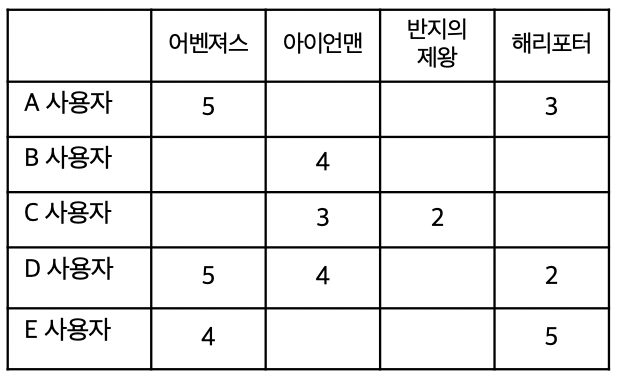

user와 item간의 선호도 프레임을 만듭시다. 우선 rating과 movie를 movieId를 기준으로 합쳐 새로운 데이터 프레임인 user_movie_rating을 만들어봅시다.

In [276]:
user_movie_rating = pd.merge(rating, movie, on = 'movieId')

In [277]:
user_movie_rating

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,5,1,4.0,847434962,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
2,7,1,4.5,1106635946,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
3,15,1,2.5,1510577970,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
4,17,1,4.5,1305696483,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),"[Action, Thriller]"
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),"[Action, Crime, Drama]"
100833,610,160836,3.0,1493844794,Hazard (2005),"[Action, Drama, Thriller]"
100834,610,163937,3.5,1493848789,Blair Witch (2016),"[Horror, Thriller]"


pivot_table 함수를 사용해서 piv2를 만듭니다. 값은 rating을 쓰고 index는 userId, columns는 movieId를 사용합니다. piv2는 아래와 같습니다. 정답과 같네요 :)

In [278]:
piv2 = user_movie_rating.pivot_table('rating', index = 'userId', columns = 'movieId')
piv2

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


==================================================================

In [297]:
# 정답
# 해당 데이터프레임은 사용자-영화 선호도 데이터프레임입니당
piv = ???????????????
piv

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


==================================================================

유사도를 구하기 위해선 전처리를 진행해야합니다. 과정은 위와 동일합니다.

In [279]:
piv2 = piv2.fillna(0)
piv2

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [281]:
CF = pd.DataFrame(cosine_similarity(piv2))
CF

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,1.000000,0.053225


In [282]:
CF.index = piv2.index
CF.columns = piv2.index
CF

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
607,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
608,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055


정답과 같네요 :)

==================================================================

In [298]:
# 사용자 간 유사도 구하기
CF = ???????????????

In [301]:
# 사용자와 사용자의 유사도를 구할 때 꼭 코사인 유사도를 사용하지 않아도 됩니당
# 보완 코사인 유사도 혹은 피어슨 상관계수를 적용해보아유
CF.index = piv.index
CF.columns = piv.index
CF

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
607,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
608,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055


==================================================================

본격적으로 코드를 짜봅시다. 코드는 아래와 같습니다. 그래프는 우선 pass... 우선 유사도가 높은 고객들 5명을 추출합니다. 또한 해당 user가 봤던 list를 추출합니다. 그리고 유사도가 높은 고객들의 영화를 별점 순으로 정리하고 이를 user가 봤던 영화들과 비교합니다. 이렇게 하는 이유는 봤던 list와 겹치지 않기 위함입니다.  
  
그리고 이를 하나의 데이터 프레임으로 나타내고 위에서부터 6개만을 뽑아봅니다.

In [359]:
def getCF(userId):
    Id = userId
    idx = CF[Id].sort_values(ascending = False)[1:6].index.values
    viewed_list = user_movie_rating[user_movie_rating['userId']==Id]['movieId'].values
    new_movie = []
    for i in idx:
        other_viewed_list = user_movie_rating[user_movie_rating['userId']==i].sort_values(by = 'rating', ascending = False)['movieId'].values
        for j in other_viewed_list:
            if j not in viewed_list:
                new_movie.append(j)
    
    for k in range(len(new_movie)):
        if k == 0 :
            recommend = movie[movie['movieId']==new_movie[k]]
        else :
            recommend = pd.concat([recommend, movie[movie['movieId']==new_movie[k]]])

    result = recommend[:6]  
    
    print('=====Recommendation List=====')
    
    return result

In [360]:
getCF(604)

=====Recommendation List=====


,movieId,title,genres
398,457,"Fugitive, The (1993)",[Thriller]
242,280,Murder in the First (1995),"[Drama, Thriller]"
278,319,Shallow Grave (1994),"[Comedy, Drama, Thriller]"
134,161,Crimson Tide (1995),"[Drama, Thriller, War]"
277,318,"Shawshank Redemption, The (1994)","[Crime, Drama]"
291,333,Tommy Boy (1995),[Comedy]


정답의 영화들을 모두 포함하고 있긴 하네요... 하지만 추후 코드를 수정할 필요는 있어보이네요...ㅠ

==================================================================

In [500]:
# 정답
# 입력 사용자와 가장 가까운 유저에서 선호도가 가장 높은 아이템 TOP5를 추천해봅시당!
# 이 때, 입력 사용자가 이미 시청한/평가한 영화는 제외해야하도록 추천 리스트를 만들어봅시당
def getCF(userId):
    '''
    
    ???????????????
    
    '''
    return

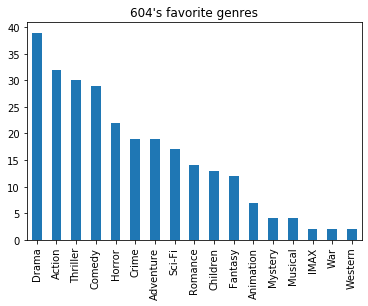


 =====Recommendation List=====


,movieId,title,genres,corpus
movieId,,,,
457,457,"Fugitive, The (1993)",Thriller,Thriller
333,333,Tommy Boy (1995),Comedy,Comedy
319,319,Shallow Grave (1994),Comedy|Drama|Thriller,Comedy Drama Thriller
318,318,"Shawshank Redemption, The (1994)",Crime|Drama,Crime Drama
280,280,Murder in the First (1995),Drama|Thriller,Drama Thriller


In [501]:
getCF(604)

==================================================================

## 3. Matrix Factorization 실습

같은 폴더에 있는 MF.py의 MatrixFactorization()을 적용해 봅시당

MF.py를 사용해보겠습니다. 계산은 위의 piv2를 바탕으로 진행하겠습니다.

In [291]:
import MF

In [302]:
factorizer = MF.MatrixFactorization(np.matrix(piv2), k=3, learning_rate=0.01, reg_param=0.01, epochs=300, verbose=True)
factorizer.fit()
R_reduced = factorizer.print_results()

Iteration: 10 ; cost = 0.0026
Iteration: 20 ; cost = 0.0026
Iteration: 30 ; cost = 0.0025
Iteration: 40 ; cost = 0.0025
Iteration: 50 ; cost = 0.0024
Iteration: 60 ; cost = 0.0024
Iteration: 70 ; cost = 0.0024
Iteration: 80 ; cost = 0.0024
Iteration: 90 ; cost = 0.0023
Iteration: 100 ; cost = 0.0023
Iteration: 110 ; cost = 0.0023
Iteration: 120 ; cost = 0.0023
Iteration: 130 ; cost = 0.0023
Iteration: 140 ; cost = 0.0023
Iteration: 150 ; cost = 0.0023
Iteration: 160 ; cost = 0.0022
Iteration: 170 ; cost = 0.0022
Iteration: 180 ; cost = 0.0022
Iteration: 190 ; cost = 0.0022
Iteration: 200 ; cost = 0.0022
Iteration: 210 ; cost = 0.0022
Iteration: 220 ; cost = 0.0022
Iteration: 230 ; cost = 0.0022
Iteration: 240 ; cost = 0.0022
Iteration: 250 ; cost = 0.0022
Iteration: 260 ; cost = 0.0022
Iteration: 270 ; cost = 0.0022
Iteration: 280 ; cost = 0.0022
Iteration: 290 ; cost = 0.0021
Iteration: 300 ; cost = 0.0021
User Latent P:
[[ 0.48392725  0.06911075  0.12372928]
 [ 0.08640306 -0.13235191

MF.py 파일을 열어서 reference를 열어봤습니다. 거기에 있는 예시를 사용해서 돌려보겠습니다. 결과는 비슷한 듯? 안 비슷하네요;;; learning rate의 차이가 있지 않을까 싶어요...

In [303]:
pd.DataFrame(R_reduced)

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,4.800503,4.182954,3.830577,3.075135,3.630489,4.937145,3.994021,3.913754,3.787586,4.446043,...,2.999309,4.103200,4.597419,4.777557,4.853564,4.952421,6.277596,3.499642,3.753939,5.222885
1,3.602588,3.670917,3.470032,1.956238,3.170519,3.792463,3.108811,3.293269,3.648989,4.061598,...,3.757509,1.500773,3.550841,3.919951,3.471828,4.316132,4.471992,1.946822,2.781785,6.445837
2,2.758115,3.627697,2.617664,1.130727,3.037361,1.919700,3.030905,2.100914,2.351975,3.928827,...,2.685350,-3.052788,1.598863,2.185320,2.659750,4.421210,6.032679,-3.273108,-0.075093,8.862516
3,4.110699,2.861181,1.990775,2.584778,1.688104,2.847933,2.600896,0.669613,0.472090,1.574089,...,-0.297997,4.703950,4.021713,0.958043,3.430343,3.562788,1.528231,3.307537,3.284291,1.251560
4,4.164191,3.403612,2.801381,2.600242,2.474252,3.446164,3.013483,1.877417,1.909389,2.720648,...,1.501791,3.812636,4.127648,2.284724,3.665578,4.073325,2.699644,3.153284,3.407955,3.391039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,3.854292,3.313732,3.085591,2.203852,2.683973,3.935311,2.929226,2.828396,2.950506,3.357797,...,2.576701,3.377027,3.952170,3.560619,3.666953,3.980311,3.800117,3.271202,3.332259,4.265990
606,3.542149,3.555700,3.628339,1.889416,3.131340,4.109742,2.947565,3.598509,4.064488,4.100459,...,4.257372,2.095501,3.797337,4.370068,3.425278,4.146773,3.970448,2.941980,3.270215,6.152991
607,3.658251,3.188619,3.005968,1.855897,2.846933,4.281233,3.060912,3.603612,3.455977,3.977648,...,2.572919,2.671366,3.407341,4.693247,3.983439,3.992839,6.588778,2.244761,2.525117,4.964797
608,3.632770,3.057432,2.857399,1.904937,2.560823,3.986574,2.821377,3.027322,2.990027,3.443180,...,2.306886,3.101749,3.580628,3.956393,3.698338,3.794332,4.968432,2.783411,2.852371,4.214120


==================================================================

In [493]:
import MF

In [491]:
# 사용자-영화 선호도 데이터프레임입니당
piv.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [492]:
# MF.py를 참고하여 인자를 입력해 보아유
factorizer = MF.MatrixFactorization({R}, k=??, learning_rate=??, reg_param=0.01, epochs=??, verbose=True)
factorizer.fit()
R_reduced = factorizer.print_results()

Iteration: 10 ; cost = 0.0024
Iteration: 20 ; cost = 0.0021
Iteration: 30 ; cost = 0.0020
Iteration: 40 ; cost = 0.0018
Iteration: 50 ; cost = 0.0017
Iteration: 60 ; cost = 0.0016
Iteration: 70 ; cost = 0.0015
Iteration: 80 ; cost = 0.0014
Iteration: 90 ; cost = 0.0013
Iteration: 100 ; cost = 0.0013
Iteration: 110 ; cost = 0.0012
Iteration: 120 ; cost = 0.0011
Iteration: 130 ; cost = 0.0011
Iteration: 140 ; cost = 0.0011
Iteration: 150 ; cost = 0.0010
Iteration: 160 ; cost = 0.0010
Iteration: 170 ; cost = 0.0010
Iteration: 180 ; cost = 0.0009
Iteration: 190 ; cost = 0.0009
Iteration: 200 ; cost = 0.0009
Iteration: 210 ; cost = 0.0009
Iteration: 220 ; cost = 0.0008
Iteration: 230 ; cost = 0.0008
Iteration: 240 ; cost = 0.0008
Iteration: 250 ; cost = 0.0008
Iteration: 260 ; cost = 0.0008
Iteration: 270 ; cost = 0.0007
Iteration: 280 ; cost = 0.0007
Iteration: 290 ; cost = 0.0007
Iteration: 300 ; cost = 0.0007
User Latent P:
[[-0.15026226  0.05531575  0.05589838 ... -0.37950053 -0.1174393

In [497]:
# Matrix Factorizaion으로 찾아낸 잠재요인을 기반으로 재생산한 행렬이네유
pd.DataFrame(R_reduced)

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,3.916813,4.478129,3.989630,5.379785,4.110406,3.985153,3.961904,2.639924,5.476944,4.276729,...,6.509292,5.524385,2.116642,2.880653,4.301188,4.462972,2.531997,6.550998,3.801199,4.647351
1,2.184512,2.647528,4.438986,3.284673,3.345467,5.661354,2.748255,5.884816,4.234426,4.672075,...,-1.178728,4.515293,-3.003231,2.025443,9.197922,8.028658,5.016721,2.849168,3.064769,-1.973399
2,2.144832,2.943030,2.545662,5.623397,2.860645,3.575103,1.021895,6.147655,-4.265640,1.858692,...,4.486339,4.060317,1.194300,-0.699251,-0.436023,5.858098,-4.860542,4.882236,1.647414,5.359447
3,3.959205,2.907817,2.102814,2.299841,2.182035,3.430950,3.910453,0.821664,3.978215,2.165412,...,0.209290,1.211698,2.032441,3.174808,1.745311,6.690086,4.037083,2.031316,-1.164085,-0.137408
4,3.964171,2.811951,3.315117,6.345289,1.525531,3.071239,3.626243,0.770739,2.839814,3.731160,...,0.306456,6.159778,4.240241,3.134073,3.038887,-1.295559,-0.689153,3.088915,-0.087376,6.419485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,3.584047,3.586055,3.117167,3.292284,3.454899,4.127064,2.899531,3.419142,3.911312,3.070247,...,4.179831,3.314298,2.560654,3.342530,4.263622,2.930955,3.043036,3.639795,4.003770,3.249624
606,3.964018,4.001081,3.304225,4.065460,3.054212,4.204882,2.263303,4.746627,3.482191,3.752764,...,1.898745,4.750200,6.627187,1.167195,7.004333,6.961326,2.975091,3.270241,3.284212,1.430936
607,2.920732,2.268228,2.067322,3.317607,1.963821,3.430579,1.579976,3.335937,1.385944,4.129249,...,3.476838,3.094610,4.916454,2.004667,1.270813,3.730215,5.886887,3.672390,-1.224488,4.392378
608,3.074765,1.799523,3.448718,4.510675,1.291637,4.346151,2.731501,2.280100,1.722135,3.971466,...,2.277239,4.412517,6.737233,4.733324,-0.618482,3.426381,2.852446,-0.553762,3.879336,3.399524


## 4. 본인만의 추천 리스트 만들어보기

배운 내용 혹은 알고 있는 추천 알고리즘을 사용해서 user의 다음 추천 아이템에 대한 TOP10 추천 리스트를 만들어 봅시당

코드를 이해할 수 있도록 주석을 꼼꼼하게 달아주시면 감사하겠습니다!

만들 추천 리스트는 movieId를 바탕으로 만들려고 합니다. 위의 content filtering을 사용하여 나온 결과 5개와 item_based_CF를 사용하여 나온 결과 5개를 합쳐 top 10을 만들 생각입니다.  
  
전체적으로 코드를 짜기 앞서 movieId를 index로 하는 새로운 pivot_table을 만들겠습니다. 과정은 위와 같으므로 부가적인 설명은 생략하겠습니다.

In [362]:
piv3 = user_movie_rating.pivot_table('rating', index = 'movieId', columns = 'userId')
piv3

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [365]:
piv3 = piv3.fillna(0)
piv3

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [368]:
CF2 = pd.DataFrame(cosine_similarity(piv3))
CF2

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [369]:
CF2.index = piv3.index
CF2.columns = piv3.index
CF2

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
193583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
193585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [377]:
def self_recommend(movieId):
    Id = movieId
    index = movie[movie['movieId'] == Id].index.values
    new_CBF = np.array(CBF)
    new_CBF = new_CBF.argsort()[:,::-1]
    sim_index = new_CBF[index,:].reshape(-1)
    sim_index = sim_index[sim_index != index]
    result = movie.iloc[sim_index][:5]
    
    idx = CF2[Id].sort_values(ascending = False)[1:6].index.values
    for k in range(len(idx)):
        if k == 0 :
            recommend = movie[movie['movieId']==idx[k]]
        else :
            recommend = pd.concat([recommend, movie[movie['movieId']==idx[k]]])
            
    result = pd.concat([result, recommend])
    
    return result

우선 content filtering을 바탕으로 진행되는 부분은 앞과 동일합니다. 우선 알고 싶은 영화의 movieId를 받아줍니다. 이를 조건으로 삼아 해당 행의 index 값을 찾습니다. 앞서 구한 CBF를 array 형식으로 바꿔주고, argsort를 사용해 오름차순으로 값을 도출할 수 있게 합니다. new_CBF의 index 행을 조건으로 삼아 해당 행을 추출하며 같은 값은 제거해줍니다. 마지막으로 sim_index를 통해 5개의 데이터를 뽑아줍니다.  
  
위에서 진행했던 CF2의 Id를 index하여 해당 행의 값을 뽑아줍니다. 그리고 이를 sort_values(ascending = False)로 크기 순으로 정렬해준 뒤, 2위부터 6위까지의 movieId를 뽑아줍니다. 1위는 자기 자신이기 때문입니다. 그리고 for문을 통해 하나씩 데이터를 쌓아가면서 총 5개의 데이터를 뽑습니다. 그리고 위의 다섯 개와 아래의 다섯 개를 합쳐 그 결과를 도출해줍니다.  
  
결과는 아래와 같습니다.

In [378]:
self_recommend(1)

,movieId,title,genres
8219,103755,Turbo (2013),"[Adventure, Animation, Children, Comedy, Fantasy]"
3568,4886,"Monsters, Inc. (2001)","[Adventure, Animation, Children, Comedy, Fantasy]"
9430,166461,Moana (2016),"[Adventure, Animation, Children, Comedy, Fantasy]"
3000,4016,"Emperor's New Groove, The (2000)","[Adventure, Animation, Children, Comedy, Fantasy]"
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)","[Adventure, Animation, Children, Comedy, Fantasy]"
2355,3114,Toy Story 2 (1999),"[Adventure, Animation, Children, Comedy, Fantasy]"
418,480,Jurassic Park (1993),"[Action, Adventure, Sci-Fi, Thriller]"
615,780,Independence Day (a.k.a. ID4) (1996),"[Action, Adventure, Sci-Fi, Thriller]"
224,260,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]"
314,356,Forrest Gump (1994),"[Comedy, Drama, Romance, War]"


# Reference  
  
https://lsjsj92.tistory.com/565  
https://simonezz.tistory.com/19